# A preliminary pipeline to collect features

In [1]:
import jusipy
import pandas as pd
import matplotlib.pylab as plt

In [2]:
# Load datasets
LM        = jusipy.deals.LandMatrix()
A_country = jusipy.country_features.All()
A_latlong = jusipy.latlong_features.All()
GLCF_8km  = A_latlong.datasets[2]         # extract from A_latlong, just to not load this one twice...

Loading GLCF(8km)                                                                                                     reas)                                                                                                      

In [3]:
# Load GIS tools
GC = jusipy.GIS.GoogleCode(cache=jusipy.utils.FireDict(sub='googlecode'))
CC = jusipy.GIS.CountryCode()
CLL = jusipy.GIS.CountryLatLong()

## Select the points, and get the relevant data

### Positive points from LandMatrix

In [21]:
positive_points = LM.M[['lat', 'long', 'target_country_iso3', 'negotiation_year']]
positive_points = positive_points.rename(columns={'target_country_iso3' : 'country',
                                                  'negotiation_year' : 'year'})
positive_points['positive'] = 1
positive_points['random']   = 0
positive_points['year'] = positive_points.year.apply(lambda x: 'newest' if pd.isna(x) else x)

### Random points selected from around the earth

In [6]:
random_points = pd.DataFrame(jusipy.GIS.sample.random_latlong(land=True, glcf=GLCF_8km, size=11000),
                             columns=['lat', 'long'])
random_points.to_pickle('data/random_points.pkl')
random_points = pd.read_pickle('data/random_points.pkl')
random_points['country'] = CLL.get(zip(random_points.lat, random_points.long))

random_points['year'] = ['newest'] * len(random_points.lat)
random_points['positive'] = 0
random_points['random']   = 1

random_points = random_points[~pd.isna(random_points.country)]

### Combine the two stacks of data

In [4]:
#all_points = pd.concat([positive_points, random_points])
#all_points.to_pickle('data/all_points.pkl')
#all_points
all_points = pd.read_pickle('data/all_points.pkl')

## Visualize the selected points

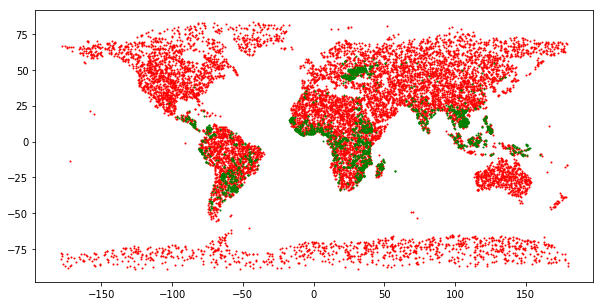

In [9]:
plt.figure(figsize=(10,5))
cb = plt.scatter(all_points.long[all_points.random == 1], all_points.lat[all_points.random ==1], c='r', s=1, zorder=1)

plt.scatter(all_points.long[all_points.random == 0], all_points.lat[all_points.random ==0], c='g', s=1, zorder=2)


## Collect features for each point

In [4]:
import jusipy
import pandas as pd
all_points = pd.read_pickle('data/all_points.pkl')
A_latlong = jusipy.latlong_features.All()
#ne = jusipy.latlong_features.NaturalEarth()
#country_features = jusipy.country_features.get(all_points, A_country)
latlong_features = jusipy.latlong_features.get(all_points, A_latlong)
#all_features = country_features.join(latlong_features)

Loading GLCF(8km)                                                                                                     reas)                                                                                                    

## Store the output

In [ ]:
all_points.to_pickle('data/all_labels.pkl')
all_features.to_pickle('data/all_features.pkl')

In [9]:
len(GC._cache._cache.keys())

5010

In [5]:
latlong_features = latlong_features.drop(columns=['coding_error_do_not_use_feature'])

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
import umap

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

class Negative(object):
    """
    Identify potentially negative deals from a random selection

    Neg = Negative(slabels, features, positive_col='positive', autorun=True, **kwargs)
        labels: A dataframe of labels
        features: A dataframe of features (columns are features) Must be none missing! Index corresponds to index of labels
        positive_col : String. The name of the column you want to use in the labels dataframe
        autorun: Run the pipeline automatically
        **kwargs: Arguments for each step (see pca, tsne, cluster and negatives for the parameters)

    properties:
        negatives: A numpy array of labels for each point, corresponding to the input dataframes
                   1 means negative, 0 means positive/not negative

    """
    def __init__(self, labels, features, positive_col='positive', autorun=True, **kwargs):
        """
        Inputs:
            labels: a dataframe of labels
            features: A dataframe of features (columns are features) Must be none missing! Index corresponds to index of labels
            positive_col : String. The name of the column you want to use in the labels dataframe
            autorun: Run the pipeline automatically
            **kwargs: Arguments for each step (see pca, tsne, cluster and negatives for the parameters)
        Output:
            A Negative structure.
            The negative labels can be retrieved with the property 'negatives'

        """
        self._labels    = labels
        self._features  = features
        self._positives = self._labels[positive_col].values
        self._znorm     = None
        self._dimred    = None
        self._clusters  = None
        self._negatives = None
        if autorun:
            self.run(**kwargs)
        #fi
    #edef

    def run(self, dimred='tsne', **kwargs):
        """
        Run the negative selection pipeline
        Input:
            dimred: String. Dimensionality reduction to use
        """
        if self._znorm is None:
            self.znorm(**kwargs)
        #fi
        if (self._dimred is None) or (dimred is not None):
            if dimred is None:
                dimred = 'tsne'
            #fi
            
            if dimred == 'pca':
                self.pca(**kwargs)
            elif dimred == 'umap':
                self.umap(**kwargs)
            else:
                self.tsne(**kwargs)
            #fi
        #fi

        if self._clusters is None:
            self.cluster(**kwargs)
        #fi
        if self._negatives is None:
            self.get_negatives(**kwargs)
        #fi
        return self._negatives
    #edef

    @property
    def negatives(self, **kwargs):
        return self._negatives
    #edef

    def znorm(self, do_znorm=True, **kwargs):
        if (self._features is None) or not (do_znorm):
            self._znorm = self._features
            return None
        #fi
        print('\rPerforming z-normalization for all features')
        self._znorm = (self._features - self._features.mean()) / self._features.std()
        return self._znorm

    def pca(self, **kwargs):
        if self._znorm is None:
            return None
        #fi
        print('\rPerforming PCA')
        pca  = PCA(n_components=2)
        pca_features  = pca.fit_transform(self._znorm)
        self._dimred = pca_features
        return self._dimred
    #edef

    def tsne(self, **kwargs):
        if self._znorm is None:
            return None
        #fi
        print('\rPerforming TSNE')
        tsne = TSNE(n_components=2)
        tsne_features = tsne.fit_transform(self._znorm)
        self._dimred = tsne_features
        return self._dimred
    #edef
    
    def umap(self, **kwargs):
        if self._znorm is None:
            return None
        #fi
        print('\rPerforming UMAP')
        self._dimred = umap.UMAP().fit_transform(self._znorm)
        return self._dimred
    #edef

    def cluster(self, method=None, bandwidth=10, **kwargs):
        """
        Cluster the embedded data
        Input:
            method: Dimensionality reduction [tsne, umap, pca]
            method: ['meanshift', 'gmm', callable object]
            bandwidth: Float. Size of kernel for meanshift
            **kwargs: arguments for the specific clustering method
        Output:
            an array of cluster IDs (of length # of points in dataset)
        """

        data = self._dimred
        
        method = method.lower()
        print('\rPerforming Clustering')
        self._clusters = None
        if method == 'gmm':
            self._clusters = GaussianMixture(**kwargs).fit_predict(data)
        elif method == 'meanshift':
            self._clusters = MeanShift(bandwidth=bandwidth, **kwargs).fit(data).labels_
        elif hasattr(method, '__call__'):
            self._clusters = method(data)
        else:
            self._clusters = MeanShift(bandwidth=bandwidth, **kwargs).fit(data).labels_
        #fi
        return self._clusters
    #edef

    def get_negatives(self, threshold=0.95, **kwargs):
        if self._clusters is None:
            return None
        #fi
        def select_negative_clusters(cluster_labels, positive_labels, threshold=.95):
            """
            Select negative clusters based on some clustering of the TSNE space
            Inputs:
                cluster_labels:  np.array: labels from the clustering
                positive_labels: np.array: labels with true positives (0 is unknown/negative, 1 is true positive)
                threshold:       The % of negative samples per cluster that are required to call it negative (default 0.95)
                                 (i.e. 0.05 positive)
            Outputs:
                a list of cluster label IDs that constitute negative clusters
            """
            clusters = list(range(max(cluster_labels)+1))
            neg_clusters = []
            for clust in clusters:
                clust_positive = positive_labels[np.where(cluster_labels == clust)]
                if (sum(clust_positive) / float(len(clust_positive))) < (1-threshold):
                    neg_clusters.append(clust)
                #fi
            #efor
            return neg_clusters
        #edef

        def select_negative_points(cluster_labels, positive_labels, threshold=0.95):
            """
            Select negative clusters based on some clustering of the TSNE space
            Inputs:
                cluster_labels:  np.array: labels from the clustering
                positive_labels: np.array: labels with true positives (0 is unknown/negative, 1 is true positive)
                threshold:       The % of negative samples per cluster that are required to call it negative (default 0.95)
                                 (i.e. 0.05 positive)
            Outputs:
                An array of negative (0) and positive (1) labels
            """
            negative_clusters = select_negative_clusters(cluster_labels, positive_labels, threshold)
            labels = np.array([ 1 ] * len(cluster_labels))
            for nc in negative_clusters:
                labels[np.where(cluster_labels == nc)] = 0
            #efor
            # Correct the true positive points we had which lie in negative clusters
            labels[np.where(positive_labels == 1)] = 1
            return negative_clusters, 1-labels
        #edef
        print('\rSelecting negatives')
        neg_clusters, negatives = select_negative_points(self._clusters, self._positives, threshold=threshold)
        self._neg_clusters = np.array([ 1 if c in neg_clusters else 0 for c in self._clusters ])
        self._negatives = negatives
        return self._negatives
    #edef

    def plot(self):
        """
        Plot the results of the pipeline
        """
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,30))
        axes = [ ax for row in axes for ax in row ]
        
        positive_color = '#1b9e77'
        random_color   = '#d95f02'
        negative_color = '#7570b3'
        
        if ('lat' in self._labels.columns) and ('long' in self._labels.columns):
            lat = self._labels.lat
            long = self._labels.long
            axes[0].set_title('World location')
            axes[0].scatter(long[self._labels.positive==1], lat[self._labels.positive==1],
                            c=positive_color, s=1, zorder=3, label='positive')
            axes[0].scatter(long[self._labels.positive==0], lat[self._labels.positive==0],
                            c=random_color, s=1, zorder=2, label='negative')

            axes[0].set_xlabel('Longitude')
            axes[0].set_ylabel('Latitude')
            axes[0].legend()
        #fi

        if self._dimred is not None:
            axes[1].set_title('Dim.Red. embedding')
            axes[1].scatter(*list(zip(*self._dimred[self._positives==1,:])), c=positive_color, s=1, zorder=2, label='positive')
            axes[1].scatter(*list(zip(*self._dimred[self._positives==0,:])), c=random_color, s=1, zorder=1, label='random')
            axes[1].set_xlabel('Dim.Red. Component 1')
            axes[1].set_ylabel('Dim.Red. Component 2')
            axes[1].legend()
        #fi

        if self._clusters is not None:
            axes[2].set_title('Dim.Red. clustering')
            axes[2].scatter(*list(zip(*self._dimred)), c=self._clusters, s=1)
            axes[2].set_xlabel('Dim.Red. Component 1')
            axes[2].set_ylabel('Dim.Red. Component 2')
            axes[2].legend()
        #fi
        
        if self._negatives is not None:
            axes[3].set_title('Negative annotation')
            axes[3].scatter(*list(zip(*self._dimred[self._neg_clusters==1,:])), c=positive_color, s=1, zorder=3, label='positive')
            axes[3].scatter(*list(zip(*self._dimred[self._neg_clusters==0,:])), c=negative_color, s=1, zorder=2, label='negative')
            axes[3].set_xlabel('Dim.Red. Component 1')
            axes[3].set_ylabel('Dim.Red. Component 2')
            axes[3].legend()
        #fi

        if self._negatives is not None:
            axes[4].set_title('Negative annotation')
            axes[4].scatter(*list(zip(*self._dimred[self._positives==1,:])), c=positive_color, s=1, zorder=3, label='positive')
            axes[4].scatter(*list(zip(*self._dimred[self._negatives==1,:])), c=negative_color, s=1, zorder=2, label='negative')
            axes[4].scatter(*list(zip(*self._dimred[((self._negatives==0) & (self._positives==0)),:])),
                            c=random_color, s=1, zorder=1, label='random')
            axes[4].set_xlabel('Dim.Red. Component 1')
            axes[4].set_ylabel('Dim.Red. Component 2')
            axes[4].legend()
        #fi
        
        if (self._negatives is not None) and ('lat' in self._labels.columns) and ('long' in self._labels.columns):
            lat = self._labels.lat
            long = self._labels.long
            axes[5].set_title('World location')
            axes[5].scatter(long[self._positives==1], lat[self._positives==1],
                            c=positive_color, s=1, zorder=3, label='positive')
            axes[5].scatter(long[self._negatives==1], lat[self._negatives==1],
                            c=negative_color, s=1, zorder=2, label='negative')

            axes[5].set_xlabel('Longitude')
            axes[5].set_ylabel('Latitude')
            axes[5].legend()
        #fi

        return fig, axes

    #edef

#eclass


neg = Negative(all_points, latlong_features, autorun=False)

In [24]:

neg.run(dimred='umap', bandwidth=2)


Performing UMAP


/Users/thiesgehrmann/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 66 separate connected components using meta-embedding (experimental)
  n_components


Performing Clustering
Selecting negatives


array([0, 0, 0, ..., 0, 0, 1])

No handles with labels found to put in legend.


[[-5.401382    0.41091028]
 [15.608666    3.0063477 ]
 [-6.6402907  -9.132002  ]
 ...
 [-7.191576   -9.560503  ]
 [-7.4110994  -3.6613922 ]
 [ 0.82168067 -6.03212   ]]


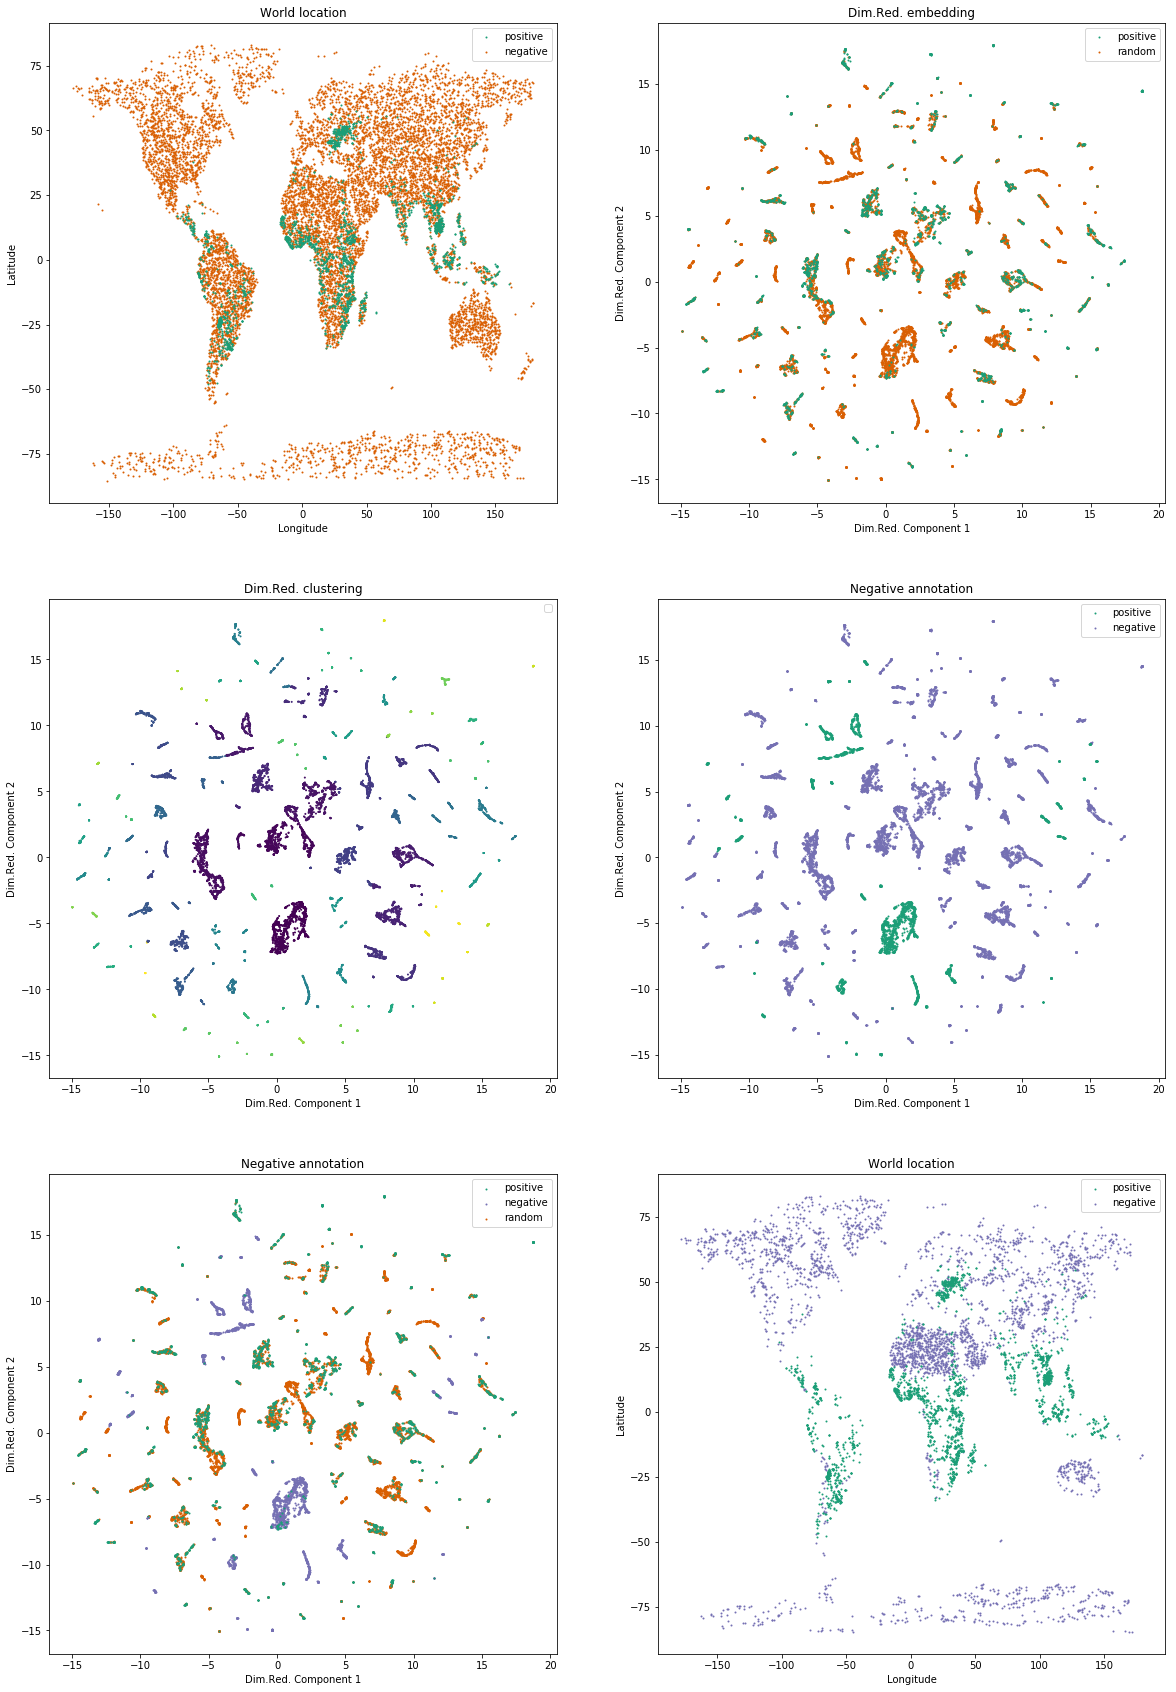

In [25]:
fig, axes = Negative.plot(neg)
print(neg._dimred)

In [26]:
sum(neg.negatives)

2930

In [20]:
neg._dimred.shape

(13433, 2)

In [2]:
umap.UMAP()

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)